### 1-1- import libraries

In [1]:
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP,EvaluatorGeneric
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem, Problem
from besos import eppy_funcs as ef, sampling
from epw import epw

import matplotlib.pyplot as plt
from seaborn import pairplot
import seaborn as sns
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn import metrics

import warnings

In [2]:
!pip install setuptools==65.5.0
!pip install pymoo==0.6.1.3

In [3]:
# import pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

### 1-2- define constant and global variables

In [4]:
# constant variables

NUM_SAMPLES = 1
idf_path = "Res_flat1.idf"
weather_file = "Torino_IT-hour.epw"
# Define the path to the CSV file
csv_file = 'simulation_outputs.csv'

In [5]:
# global variables 
INPUT_PARAMETERS = []

### 1-3- base variables based on idf and epw files

In [6]:
# Load the IDF file
building = ef.get_building(idf_path)

# Load and retrieve the epw file as a dataFrame
meteo = epw()
meteo.read(weather_file)
meteo.dataframe.head()

,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
0,2005,1,1,1,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,13.3,-1.1,37,98488,...,99999,9,999999999,9,0.094,0,4,0.2,0.0,99.0
1,2005,1,1,2,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,12.8,-0.9,39,98488,...,99999,9,999999999,9,0.094,0,4,0.2,0.0,99.0
2,2005,1,1,3,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,12.2,-1.5,38,98488,...,99999,9,999999999,8,0.094,0,4,0.2,0.0,99.0
3,2005,1,1,4,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,11.9,-1.7,38,98488,...,99999,9,999999999,8,0.094,0,4,0.2,0.0,99.0
4,2005,1,1,5,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,11.6,-2.0,38,98488,...,99999,9,999999999,8,0.094,0,4,0.2,0.0,99.0


# 2- INPUT PARAMETERS

### 2-1- INSULATION

- **roof**: MW Glass Wool (rolls)_.0001, !is applied to the ROOF  <br>
- **wall**: _Insulation_.0001, !is applied to WALLS 

#### 2-1-1 roof
for roofs, we can only change the thickness of the Glass Wool. Although conductivity has a great impact on thermal comfort, but we cannot change glass wool's conductivity. The same is true for its other fields (e.g. Density, Specific Heat, etc.).

In [7]:
# roof insulation

# selector
roof_ins_sel = FieldSelector(
                class_name = 'Material', 
                object_name = 'MW Glass Wool (rolls)_.0001', 
                field_name = 'Thickness')
# range
roof_ins_range = RangeParameter(min_val = 0.1, max_val=0.9) 
roof_ins_param = Parameter(
                selector=roof_ins_sel, 
                value_descriptors=roof_ins_range, 
                name='Roof Insulation')
# append to the list of input parameter
INPUT_PARAMETERS.append(roof_ins_param)

#### 2-1-2 wall
for wall, it is the same story as we told about roof. 

In [8]:
# wall insulation

# selector
wall_ins_sel = FieldSelector(
                class_name = 'Material', 
                object_name = '_Insulation_.0001', 
                field_name = 'Thickness')
# range
wall_ins_range = RangeParameter(min_val = 0.01, max_val=0.09) #min_val = 0.0001, max_val=0.0009
# parameter
wall_ins_param = Parameter(
                selector=wall_ins_sel, 
                value_descriptors=wall_ins_range, 
                name='Wall Insulation')
# append to the list of input parameter
INPUT_PARAMETERS.append(wall_ins_param)

### 2-2- WINDOW


In [9]:
windows = [obj for obj in building.idfobjects["fenestrationsurface:detailed"] if "Win" in obj.Name]
windows

[
 FenestrationSurface:Detailed,
     StairXnoHVAC:Zona1_Wall_2_1_0_0_0_0_Win,    !- Name
     Window,                   !- Surface Type
     Dbl LoE (e2=.1) Clr 6mm/13mm Arg - 1001,    !- Construction Name
     StairXnoHVAC:Zona1_Wall_2_1_0,    !- Building Surface Name
     ,                         !- Outside Boundary Condition Object
     AutoCalculate,            !- View Factor to Ground
     1,                        !- Frame and Divider Name
     1,                        !- Multiplier
     4,                        !- Number of Vertices
     3.5,                      !- Vertex 1 Xcoordinate
     5.615,                    !- Vertex 1 Ycoordinate
     0.84,                     !- Vertex 1 Zcoordinate
     3.5,                      !- Vertex 2 Xcoordinate
     6.135,                    !- Vertex 2 Ycoordinate
     0.84,                     !- Vertex 2 Zcoordinate
     3.5,                      !- Vertex 3 Xcoordinate
     6.135,                    !- Vertex 3 Ycoordinate
     2.26,

In [10]:
# # window type


# # categories
# windows_list = [
#     "Sgl Clr 6mm - 1001",
#     "Sgl Clr 6mm - 2001",
#     "Dbl LoE (e2=.1) Clr 6mm/13 mm Arg - 1003",
#     "Dbl LoE (e2=.1) Clr 6mm/13mm Arg - 2003",
#     "Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002",
#     "Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 2002"
# ]
# windows_categories = CategoryParameter(windows_list)


# # parameter
# windowsParameters = []
# for fenestration in building.idfobjects["FenestrationSurface:Detailed"]:
#     if fenestration.obj[2] == "Window":
#         sel = FieldSelector(
#             class_name ='FenestrationSurface:Detailed', 
#             object_name = fenestration.Name, 
#             field_name='Construction Name' )
#         windowsParameters.append(Parameter(
#             selector=sel, 
#             value_descriptors = windows_categories, 
#             name='Windows types'))



# # append to the list of input parameter
# INPUT_PARAMETERS = INPUT_PARAMETERS + windowsParameters

### 2-3- LIGHTING (artificial)

In [11]:
# lighting

# selector
lighting_sel = FieldSelector(
                class_name = 'Lights', 
                object_name = '*', 
                field_name = 'Watts per Zone Floor Area')
# range
lighting_range = RangeParameter(min_val = 2, max_val=5) 
lighting_param = Parameter(
                selector= lighting_sel, 
                value_descriptors=lighting_range, 
                name='Lighting watt/zone_floor_area')
# append to the list of input parameter
INPUT_PARAMETERS.append(lighting_param)

### 2-4- SHADING control

### 2-5- NATURAL(or fan) VENTILATION – Blocco1 

 
- first, we have to change the idf so that: Design Volume Flow Rate calculation method: Flow/Zone => AirChanges/Hour
- then, we have to add values for "Air Changes Per Hour"

In [12]:
# Modify the value in the IDF file
for obj in building.idfobjects['ZoneVentilation:DesignFlowRate']:
    obj.Design_Flow_Rate_Calculation_Method = "AirChanges/Hour"  # Set to desired value

In [13]:
# ventACH

# selector
ventACH_sel = FieldSelector(
                class_name = 'ZoneVentilation:DesignFlowRate', 
                object_name = '*', 
                field_name = 'Air Changes per Hour')

# range
ventACH_range = RangeParameter(min_val = 0.0, max_val=6.0) 
ventACH_param = Parameter(
                selector= ventACH_sel, 
                value_descriptors=ventACH_range, 
                name='Ventilation ACH')
# append to the list of input parameter
INPUT_PARAMETERS.append(ventACH_param)

### 2-7- Mechanical Ventilation

In [14]:
# mechanical ventilation

# selector
mech_vent_sel = FieldSelector(
                class_name = 'DesignSpecification:OutdoorAir', 
                object_name = '*', 
                field_name = 'Outdoor Air Flow per Person')
# range
mech_vent_range = RangeParameter(min_val = 0.01, max_val=0.15) 
mech_vent_param = Parameter(
                selector= mech_vent_sel, 
                value_descriptors=mech_vent_range, 
                name='Mech. Vent. OutdoorAirFlow/Person')
# append to the list of input parameter
INPUT_PARAMETERS.append(mech_vent_param)

# 3- OUTPUT PARAMETERS

In [15]:
INPUT_PARAMETERS

[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='MW Glass Wool (rolls)_.0001'), value_descriptors=[RangeParameter(min=0.1, max=0.9)]),
 Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='_Insulation_.0001'), value_descriptors=[RangeParameter(min=0.01, max=0.09)]),
 Parameter(selector=FieldSelector(field_name='Watts per Zone Floor Area', class_name='Lights', object_name='*'), value_descriptors=[RangeParameter(min=2, max=5)]),
 Parameter(selector=FieldSelector(field_name='Air Changes per Hour', class_name='ZoneVentilation:DesignFlowRate', object_name='*'), value_descriptors=[RangeParameter(min=0.0, max=6.0)]),
 Parameter(selector=FieldSelector(field_name='Outdoor Air Flow per Person', class_name='DesignSpecification:OutdoorAir', object_name='*'), value_descriptors=[RangeParameter(min=0.01, max=0.15)])]

In [16]:
len(INPUT_PARAMETERS)

5

In [17]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

# 4- PROBLEM DIFINITION

In [18]:
problem=EPProblem(INPUT_PARAMETERS, objectives) # problem = parameters + objectives

print(problem.names())

['Roof Insulation', 'Wall Insulation', 'Lighting watt/zone_floor_area', 'Ventilation ACH', 'Mech. Vent. OutdoorAirFlow/Person', 'Electricity:Facility', 'DistrictHeating:Facility', 'DistrictCooling:Facility']


# 5- SAMPLE GENERATION

In [19]:
# Generating samples for optimization using Latin Hypercube Sampling (LHS) method
samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=NUM_SAMPLES)


In [20]:
samples

,Roof Insulation,Wall Insulation,Lighting watt/zone_floor_area,Ventilation ACH,Mech. Vent. OutdoorAirFlow/Person
0,0.448507,0.066148,2.786269,5.947742,0.020105


# 6- EVALUATOR

In [21]:
# Creating an EvaluatorEP object for evaluating the optimization problem
evaluator = EvaluatorEP(problem, building, out_dir='outputdir', err_dir='outputdir',epw=weather_file)


In [22]:
# Function to append new records to CSV
def save_outputs_to_csv(new_data):
    # Convert outputs to dataframe (if needed)
    if not isinstance(new_data, pd.DataFrame):
        new_data = pd.DataFrame(new_data)

    # Check if file exists
    if not os.path.isfile(csv_file):
        # Write new data to a new CSV (including header)
        new_data.to_csv(csv_file, mode='w', index=False)
        print(f"New file created: {csv_file}")
    else:
        # Append new data without writing the header
        new_data.to_csv(csv_file, mode='a', index=False, header=False)
        print(f"Data appended to: {csv_file}")

uncomment the below, if you want to generate samples

In [23]:
# # Applying the evaluator to the generated samples and keeping input data
# outputs = evaluator.df_apply(samples, keep_input=True)
# outputs
# # use the function to store the outputs
# save_outputs_to_csv(outputs)

# 7- Read the evaluation output file

In [24]:
# Read the CSV file into a DataFrame
def read_outputs(csv_file):
    if os.path.isfile(csv_file):
        outputs = pd.read_csv(csv_file)
        return outputs
    else:
        print(f"No file found at: {csv_file}")
        return None

outputs = read_outputs(csv_file)
outputs

,Roof Insulation,Wall Insulation,Lighting watt/zone_floor_area,Ventilation ACH,Mech. Vent. OutdoorAirFlow/Person,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.279617,0.024683,3.102466,3.824671,0.046088,6.053054e+09,1.663531e+10,3.126719e+09
1,0.884193,0.067793,3.819560,0.697047,0.146036,6.171255e+09,2.149829e+10,2.331995e+09
2,0.127462,0.033325,2.507173,5.208567,0.072580,5.954929e+09,1.975865e+10,3.244363e+09
3,0.156574,0.041375,2.632800,3.920000,0.056322,5.975637e+09,1.777866e+10,3.273032e+09
4,0.197715,0.037311,2.946186,5.305412,0.084789,6.027294e+09,1.959760e+10,2.758389e+09
...,...,...,...,...,...,...,...,...
179,0.584539,0.024838,3.939621,4.007710,0.086057,6.191045e+09,1.896648e+10,2.541056e+09
180,0.736864,0.031053,4.382529,4.265973,0.112133,6.264051e+09,2.033272e+10,2.288179e+09
181,0.504873,0.073263,3.027123,0.480432,0.138810,6.040635e+09,2.132308e+10,2.511513e+09
182,0.771543,0.013751,4.879642,5.530667,0.114267,6.345992e+09,2.133254e+10,2.432918e+09


# visualization

<Figure size 432x288 with 0 Axes>

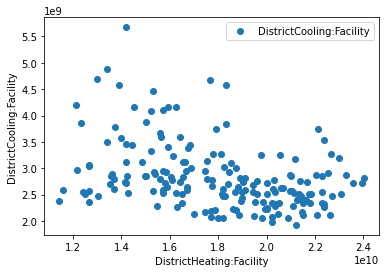

In [25]:
# Plotting the data points for district heating vs. district cooling
plt.figure()
_ = outputs.plot(x=objectives[1], y=objectives[2], style = 'o')
plt.xlabel(objectives[1])
plt.ylabel(objectives[2])
plt.savefig('heating_cooling.png', format='png', dpi=600)
plt.show()

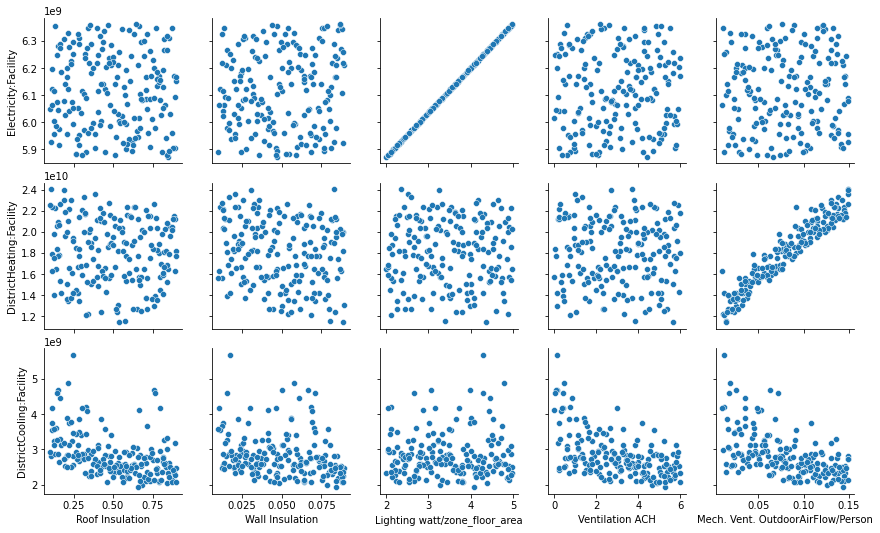

In [26]:
# Visualize the relationships between optimization parameters and objectives
_=pairplot(outputs,x_vars=samples.columns, y_vars=objectives, kind="scatter")
plt.savefig('all.png', format='png', dpi=600)

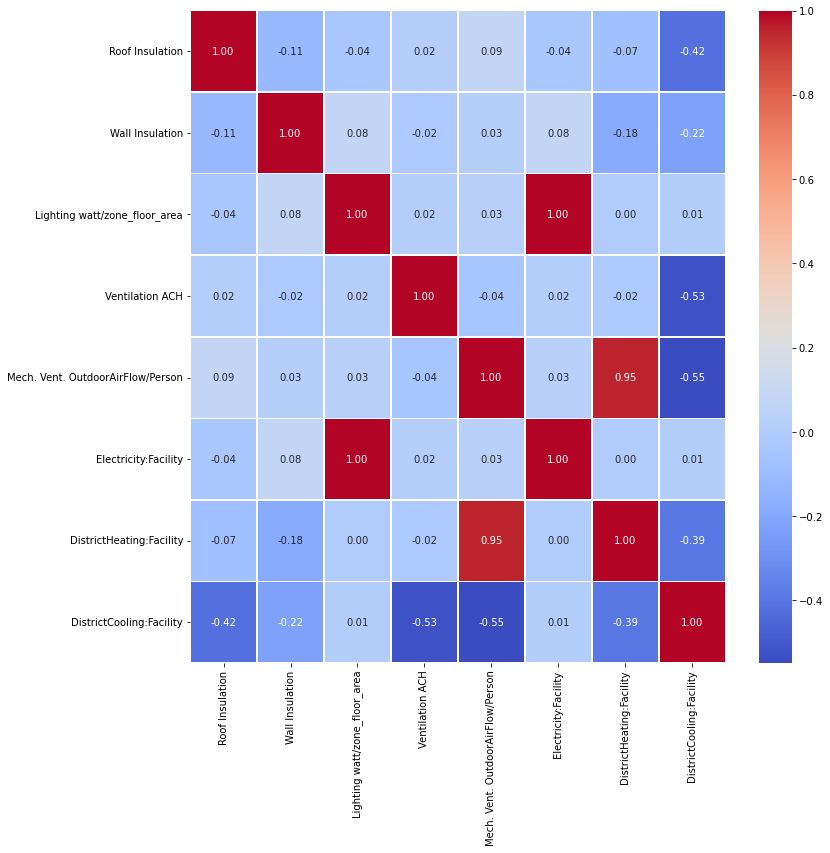

In [27]:
plt.figure(figsize=(12, 12))
sns.heatmap(outputs.corr(), annot=True, fmt=".2f", linewidth=.5, cmap='coolwarm')
plt.show()

### normalize the matrix

In [28]:
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(outputs), columns=outputs.columns)

### add the total consumption from the normalized data

In [29]:
# Creating a new DataFrame for outputs with total consumption calculated
normalized_total = normalized_data.copy()
normalized_total["TotConsumption"] = normalized_total["DistrictCooling:Facility"] + normalized_total["DistrictHeating:Facility"] + normalized_total["Electricity:Facility"]
normalized_total.to_csv('normalized_total.csv', index=True)
normalized_total

,Roof Insulation,Wall Insulation,Lighting watt/zone_floor_area,Ventilation ACH,Mech. Vent. OutdoorAirFlow/Person,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,TotConsumption
0,0.220556,0.182277,0.368713,0.637945,0.258144,0.368713,0.413089,0.320454,1.102255
1,0.981412,0.728602,0.610653,0.114599,0.978514,0.610653,0.799469,0.108468,1.518590
2,0.029070,0.291804,0.167866,0.869513,0.449084,0.167866,0.661249,0.351834,1.180950
3,0.065708,0.393818,0.210252,0.653897,0.331905,0.210252,0.503931,0.359481,1.073665
4,0.117483,0.342320,0.315985,0.885718,0.537082,0.315985,0.648452,0.222205,1.186642
...,...,...,...,...,...,...,...,...,...
179,0.604299,0.184253,0.651160,0.668573,0.546219,0.651160,0.598308,0.164233,1.413702
180,0.796000,0.263010,0.800593,0.711789,0.734156,0.800593,0.706861,0.096781,1.604234
181,0.504040,0.797924,0.343292,0.078353,0.926427,0.343292,0.785548,0.156353,1.285193
182,0.839643,0.043746,0.968314,0.923410,0.749542,0.968314,0.786299,0.135388,1.890002


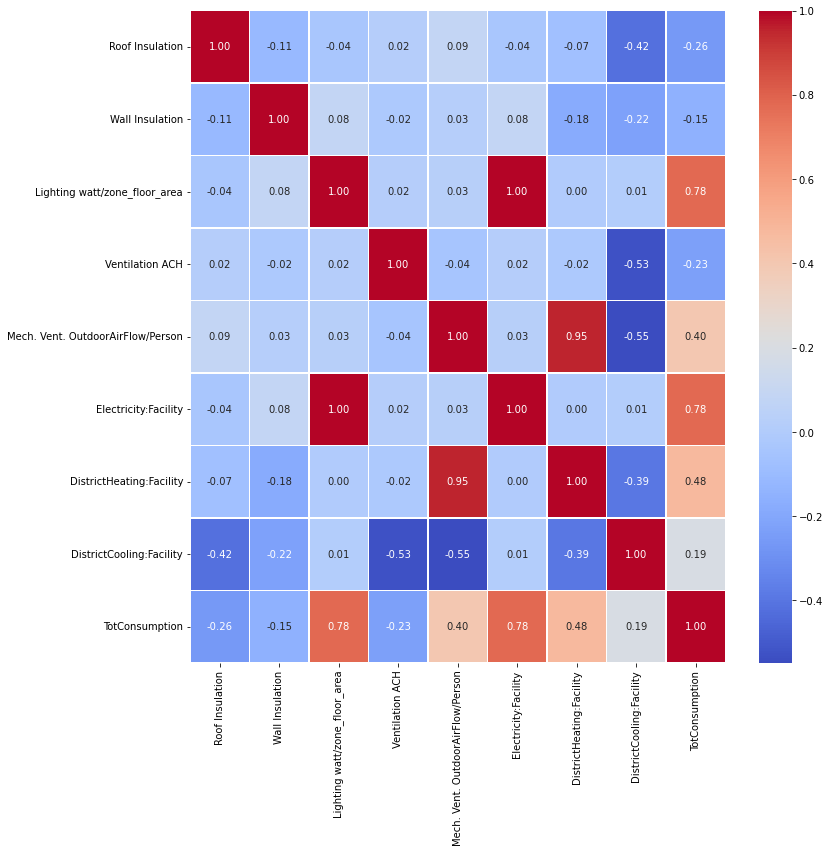

In [30]:
plt.figure(figsize=(12, 12))
sns.heatmap(normalized_total.corr(), annot=True, fmt=".2f", linewidth=.5, cmap='coolwarm')
plt.show()

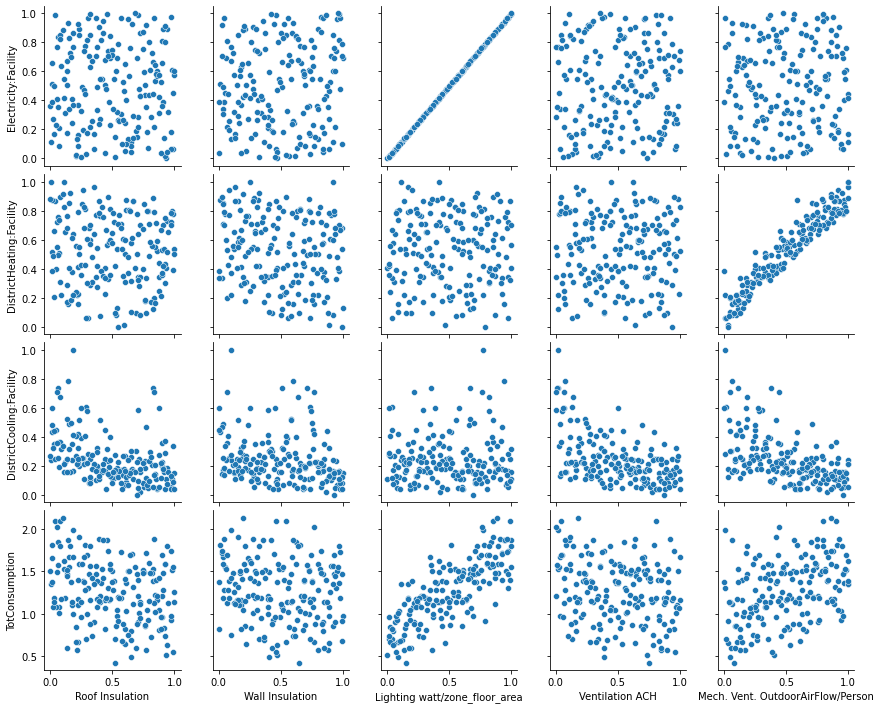

In [31]:
_=pairplot(normalized_total,x_vars=samples.columns, y_vars=objectives+['TotConsumption'], kind="scatter")
plt.savefig('all.png', format='png', dpi=600)

# 8- SURROGATE MODEL

In [32]:
data = normalized_data
data.head()

,Roof Insulation,Wall Insulation,Lighting watt/zone_floor_area,Ventilation ACH,Mech. Vent. OutdoorAirFlow/Person,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.220556,0.182277,0.368713,0.637945,0.258144,0.368713,0.413089,0.320454
1,0.981412,0.728602,0.610653,0.114599,0.978514,0.610653,0.799469,0.108468
2,0.029070,0.291804,0.167866,0.869513,0.449084,0.167866,0.661249,0.351834
3,0.065708,0.393818,0.210252,0.653897,0.331905,0.210252,0.503931,0.359481
4,0.117483,0.342320,0.315985,0.885718,0.537082,0.315985,0.648452,0.222205


In [33]:
input = data.iloc[:, :5]
output = data.iloc[:, 5:]

In [34]:
input.head()

,Roof Insulation,Wall Insulation,Lighting watt/zone_floor_area,Ventilation ACH,Mech. Vent. OutdoorAirFlow/Person
0,0.220556,0.182277,0.368713,0.637945,0.258144
1,0.981412,0.728602,0.610653,0.114599,0.978514
2,0.029070,0.291804,0.167866,0.869513,0.449084
3,0.065708,0.393818,0.210252,0.653897,0.331905
4,0.117483,0.342320,0.315985,0.885718,0.537082


In [35]:
output.head()

,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.368713,0.413089,0.320454
1,0.610653,0.799469,0.108468
2,0.167866,0.661249,0.351834
3,0.210252,0.503931,0.359481
4,0.315985,0.648452,0.222205


In [36]:
X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.33, random_state=100)

Note: in the case of *multi-output regression*, we technically have two main options:
- **Option 1: Train Separate Models for Each Output**: If the outputs are independent or have different relationships with the input features, it's better to train a separate model for each target variable:
- **Option 2: Train a Single Model for All Outputs**: If the outputs are correlated or if the model can handle multi-output regression (like Gaussian Process Regressor or Random Forest Regressor), you can train a single model on the whole target set. 



**In our Case:**
Since the outputs (Electricity, District Heating, District Cooling) are related to the building's total energy consumption, they are likely correlated. Therefore, training a single model for all outputs together makes sense. 

In [37]:
gp_model = GaussianProcessRegressor().fit(X_train, y_train)

In [38]:
y_pred = gp_model.predict(X_test)

The R² score (coefficient of determination) measures how well a model predicts the target variable. Its value ranges from -∞ to 1:
- **1** : Perfect prediction — the model explains 100% of the variance.
- **0 to 1** : The model explains part of the variance; higher values are better.
- **0** : The model explains no variance — it's as good as predicting the mean of the target values.

- **< 0** : The model is worse than simply predicting the mean — the model adds noise.


In [39]:
metrics.r2_score(y_test, y_pred)

0.9716700021496898

In [40]:
# Compute R2 score for each target
r2_scores = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
for i, col in enumerate(output.columns):
    print(f"R2 score for {col}: {r2_scores[i]}")

R2 score for Electricity:Facility: 0.9997070382176334
R2 score for DistrictHeating:Facility: 0.9927287331265987
R2 score for DistrictCooling:Facility: 0.9225742351048373


In [41]:
# Train GPR models for each output
models = []
for i in range(y_train.shape[1]):
    model = GaussianProcessRegressor()
    model.fit(X_train, y_train.iloc[:, i])
    models.append(model)

In [42]:
# from pymoo.core.problem import Problem
# import numpy as np

class MyProblem(Problem):
    def __init__(self):
        # Pass parameters directly to the parent class using `super().__init__`
        super().__init__(n_var=5,               # Number of input variables
                         n_obj=3,               # Number of objectives
                         n_constr=0,            # Number of constraints
                         xl=np.array([0, 0, 0, 0, 0]),  # Lower bounds
                         xu=np.array([1, 1, 1, 1, 1]))  # Upper bounds
        
    def _evaluate(self, X, out, *args, **kwargs):
        # Example objective functions (replace with your logic)
        out["F"] = np.column_stack([
            X[:, 0]**2 + X[:, 1]**2,       # First objective
            (X[:, 2] - 1)**2 + X[:, 3]**2,  # Second objective
            np.sin(X[:, 4])                # Third objective
        ])

# Create the problem
problem = MyProblem()

### Set Up and Solve the Problem


In [43]:
# Initialize NSGA-II algorithm
algorithm = NSGA2(pop_size=100)

# Optimize the problem
result = minimize(problem,
                  algorithm,
                  termination=('n_gen', 100),
                  seed=1,
                  verbose=True)

# Get the Pareto front (optimal trade-offs)
pareto_front = result.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     16 |             - |             -
     2 |      200 |     22 |  0.0075478389 |         ideal
     3 |      300 |     14 |  1.2833389454 |         nadir
     4 |      400 |     12 |  0.0068978269 |         ideal
     5 |      500 |     14 |  0.0082079464 |         ideal
     6 |      600 |     20 |  0.4619122869 |         nadir
     7 |      700 |     14 |  3.4553431755 |         nadir
     8 |      800 |     20 |  0.1149057847 |         nadir
     9 |      900 |     33 |  0.7579949568 |         nadir
    10 |     1000 |     38 |  1.1081452880 |         nadir
    11 |     1100 |     44 |  0.3039698747 |         nadir
    12 |     1200 |     23 |  1.092343E+01 |         nadir
    13 |     1300 |     34 |  0.1631012738 |         nadir
    14 |     1400 |     19 |  6.1480477813 |         nadir
    15 |     1500 |     22 |  1.4989159440 |         nadir
    16 |     1600 |     17 |  2.4076847931 |         nad